# Importando Bibliotecas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

# Importação do Dataset

In [ ]:
torch.manual_seed(123) # Setando a semente no processador

In [ ]:
transform = transforms.ToTensor()

In [ ]:
X_train = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(X_train, batch_size=256)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Construcao do Gerador

In [ ]:
class model_gerador(nn.Module):

  def __init__(self):
    super().__init__()
    # 256 Entradas
    self.dense0 = nn.Linear(100, 32)
    self.dense1 = nn.Linear(32, 64)
    self.dense2 = nn.Linear(64, 128)
    self.dense3 = nn.Linear(128, 784) # Imagens do MDIST 28x28 784 que vai ser a entrada para outra rede
    self.dropout = nn.Dropout(0.3)

  def forward(self, X):
    # Leaky_relu Pode devolver valores negativos, parametros é a entradas e o fator de conversão 0.2
    X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
    X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
    X = torch.tanh(self.dense3(X))
    X = X.view(X.shape[0],1, 28, 28) # O X estava em formato de array 784 nesta linha volta no formato de imagem
    return X 

# Construção do Discriminador

In [ ]:
class model_discriminator(nn.Module):
    def __init__(self):
       super().__init__() 
       #output =(input -filter + 1)/stride
       #convulação (28 - 3 +1)/1 = 26x26
       #pooling 1: 13x13
       #convulação 2: (13 - 3 + 1)/ 1 = 11 = 10x10
       #pooling 2: 5x5
       self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
       self.conv2 = nn.Conv2d(32, 32, (3,3))
       self.activation = nn.ReLU()
       self.bnorm = nn.BatchNorm2d(num_features=32)
       self.pool = nn.MaxPool2d(kernel_size=(2,2))
       self.flatten = nn.Flatten()

       #definir a camada densa
       self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
       self.linear2 = nn.Linear(128,128)
       self.output = nn.Linear(128,1)
       self.dropout = nn.Dropout(0.2)
    
    def forward(self, X):
        #primeira camada de convolução
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)
        #camada densa
        X = self.dropout((self.activation(self.linear1(X))))
        X = self.dropout((self.activation(self.linear2(X))))
        X = self.output(X)
        return X

# Criação dos Objetos

In [ ]:
G = model_gerador()
D = model_discriminator()

In [ ]:
G_optimizer = optim.Adam(G.parameters(), lr=0.002)
D_optimizer = optim.Adam(D.parameters(), lr=0.002)

In [ ]:
criterion = nn.BCEWithLogitsLoss() # Calcula a binary cross entropy 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [ ]:
G.to(device)
D.to(device)

model_discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Época   1 Finalizada: Custo Discriminador 0.00371 - Custo Gerador 0.10875


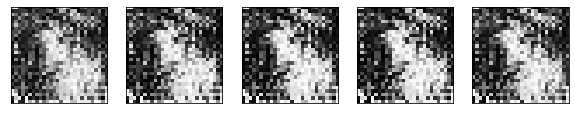

Época   2 Finalizada: Custo Discriminador 0.00350 - Custo Gerador 0.15239


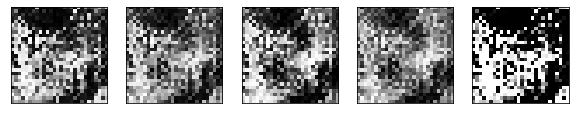

Época   3 Finalizada: Custo Discriminador 0.00379 - Custo Gerador 0.14672


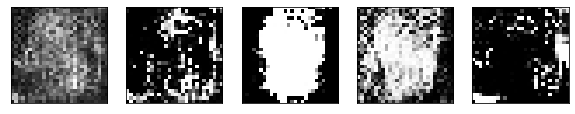

Época   4 Finalizada: Custo Discriminador 0.00374 - Custo Gerador 0.14291


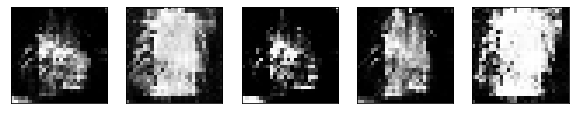

Época   5 Finalizada: Custo Discriminador 0.00375 - Custo Gerador 0.14170


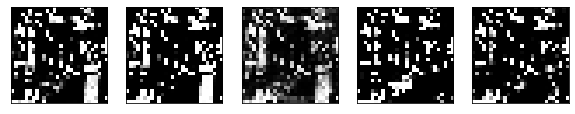

Época   6 Finalizada: Custo Discriminador 0.00353 - Custo Gerador 0.16459


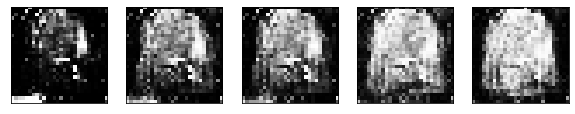

Época   7 Finalizada: Custo Discriminador 0.00367 - Custo Gerador 0.15787


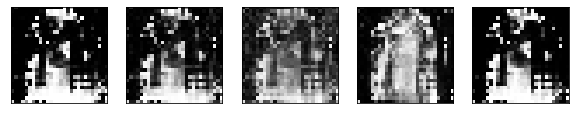

Época   8 Finalizada: Custo Discriminador 0.00351 - Custo Gerador 0.16896


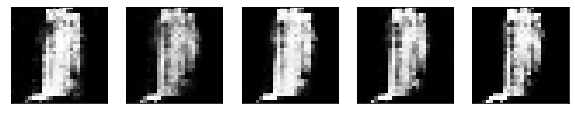

Época   9 Finalizada: Custo Discriminador 0.00351 - Custo Gerador 0.15120


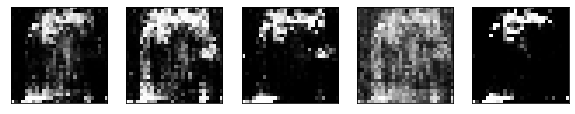

Época  10 Finalizada: Custo Discriminador 0.00376 - Custo Gerador 0.13599


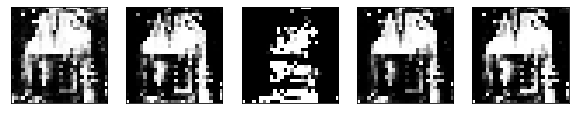

Época  11 Finalizada: Custo Discriminador 0.00361 - Custo Gerador 0.17301


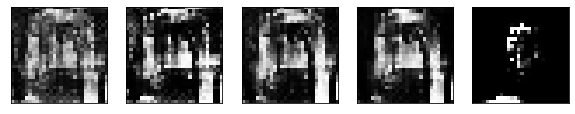

Época  12 Finalizada: Custo Discriminador 0.00360 - Custo Gerador 0.16019


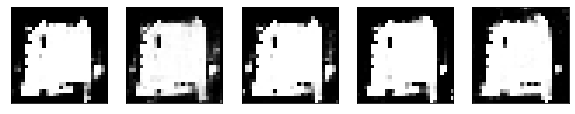

Época  13 Finalizada: Custo Discriminador 0.00360 - Custo Gerador 0.15449


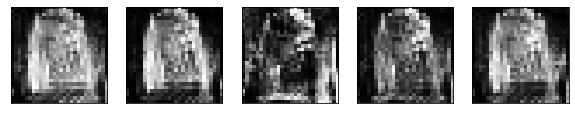

Época  14 Finalizada: Custo Discriminador 0.00363 - Custo Gerador 0.14484


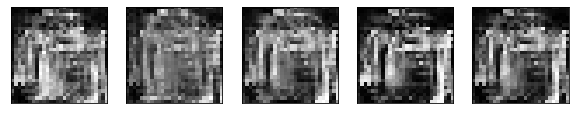

Época  15 Finalizada: Custo Discriminador 0.00344 - Custo Gerador 0.17365


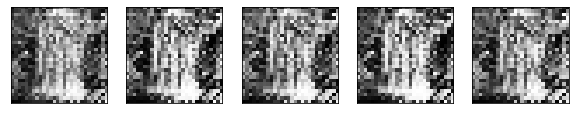

Época  16 Finalizada: Custo Discriminador 0.00349 - Custo Gerador 0.24468


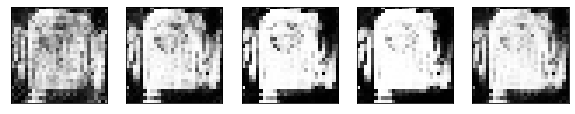

Época  17 Finalizada: Custo Discriminador 0.00363 - Custo Gerador 0.18777


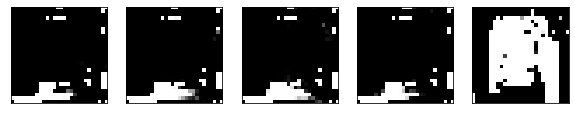

Época  18 Finalizada: Custo Discriminador 0.00343 - Custo Gerador 0.17341


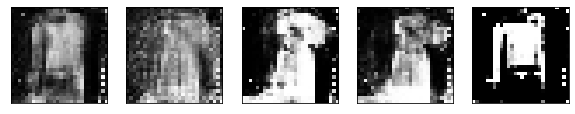

Época  19 Finalizada: Custo Discriminador 0.00355 - Custo Gerador 0.14976


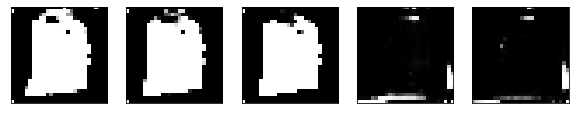

Época  20 Finalizada: Custo Discriminador 0.00352 - Custo Gerador 0.16992


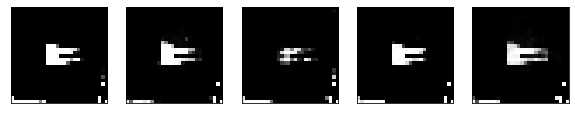

Época  21 Finalizada: Custo Discriminador 0.00361 - Custo Gerador 0.17069


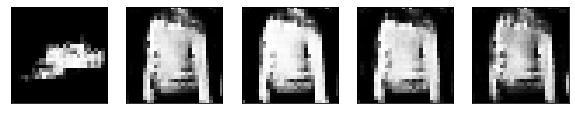

Época  22 Finalizada: Custo Discriminador 0.00371 - Custo Gerador 0.14389


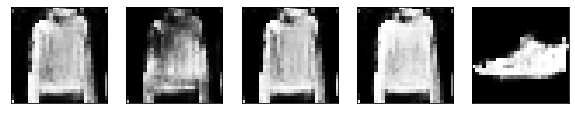

Época  23 Finalizada: Custo Discriminador 0.00383 - Custo Gerador 0.12347


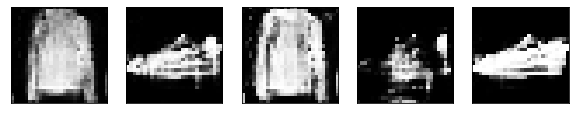

Época  24 Finalizada: Custo Discriminador 0.00372 - Custo Gerador 0.10841


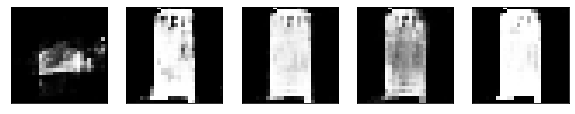

Época  25 Finalizada: Custo Discriminador 0.00377 - Custo Gerador 0.13250


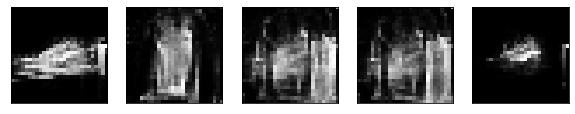

Época  26 Finalizada: Custo Discriminador 0.00391 - Custo Gerador 0.11422


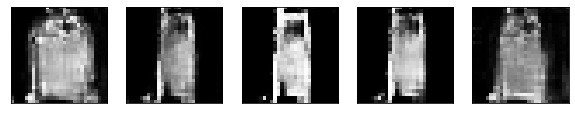

Época  27 Finalizada: Custo Discriminador 0.00365 - Custo Gerador 0.11053


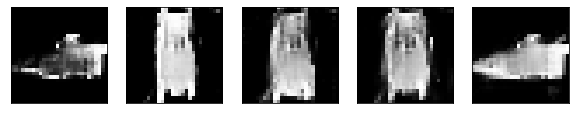

Época  28 Finalizada: Custo Discriminador 0.00360 - Custo Gerador 0.13356


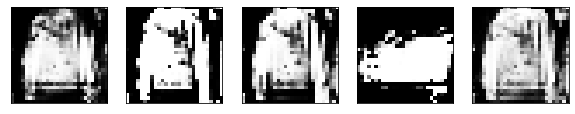

Época  29 Finalizada: Custo Discriminador 0.00349 - Custo Gerador 0.14746


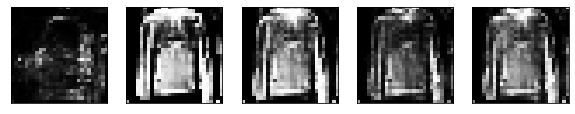

Época  30 Finalizada: Custo Discriminador 0.00406 - Custo Gerador 0.13464


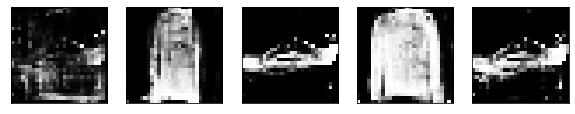

Época  31 Finalizada: Custo Discriminador 0.00372 - Custo Gerador 0.11836


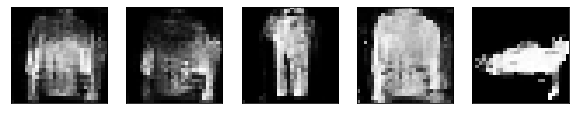

Época  32 Finalizada: Custo Discriminador 0.00392 - Custo Gerador 0.08972


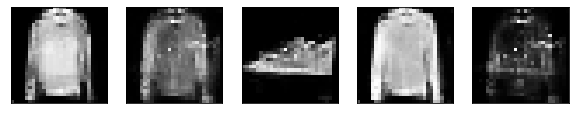

Época  33 Finalizada: Custo Discriminador 0.00372 - Custo Gerador 0.15253


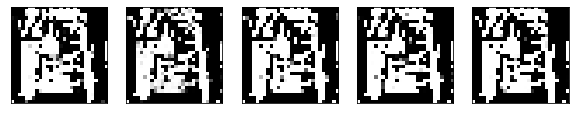

Época  34 Finalizada: Custo Discriminador 0.00342 - Custo Gerador 0.16685


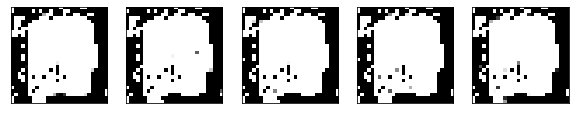

Época  35 Finalizada: Custo Discriminador 0.00341 - Custo Gerador 0.23701


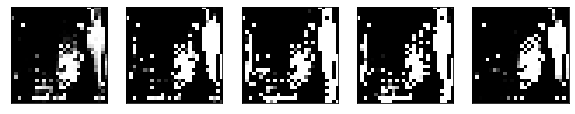

Época  36 Finalizada: Custo Discriminador 0.00339 - Custo Gerador 0.14372


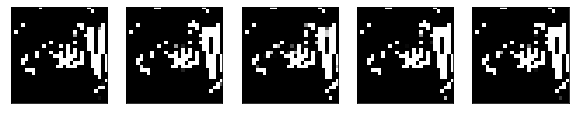

Época  37 Finalizada: Custo Discriminador 0.00339 - Custo Gerador 0.14582


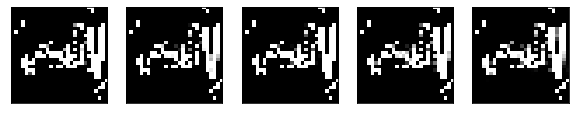

Época  38 Finalizada: Custo Discriminador 0.00342 - Custo Gerador 0.20693


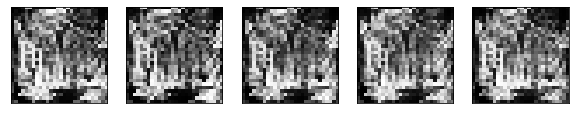

Época  39 Finalizada: Custo Discriminador 0.00346 - Custo Gerador 0.26244


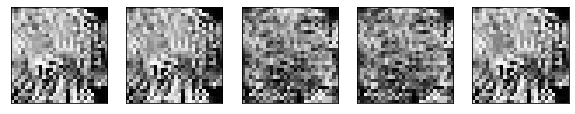

Época  40 Finalizada: Custo Discriminador 0.00368 - Custo Gerador 0.26054


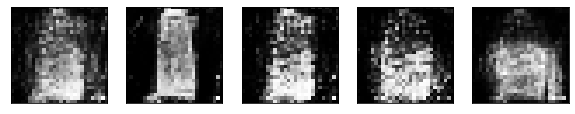

Época  41 Finalizada: Custo Discriminador 0.00346 - Custo Gerador 0.18081


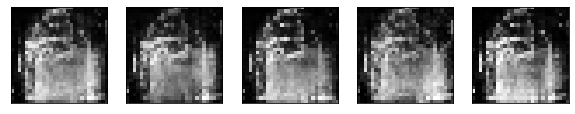

Época  42 Finalizada: Custo Discriminador 0.00342 - Custo Gerador 0.18636


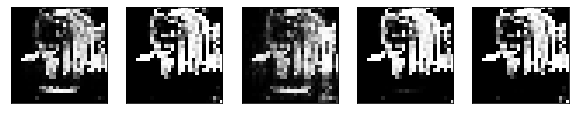

Época  43 Finalizada: Custo Discriminador 0.00342 - Custo Gerador 0.25536


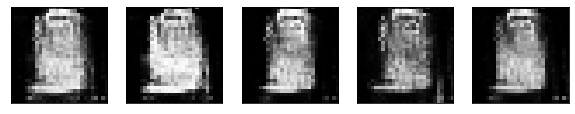

Época  44 Finalizada: Custo Discriminador 0.00358 - Custo Gerador 0.26090


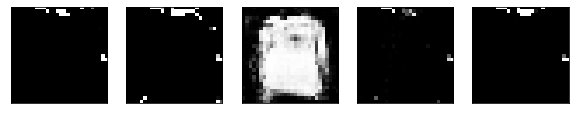

Época  45 Finalizada: Custo Discriminador 0.00353 - Custo Gerador 0.21182


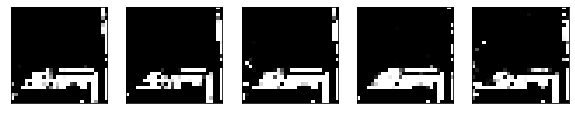

Época  46 Finalizada: Custo Discriminador 0.00342 - Custo Gerador 0.29534


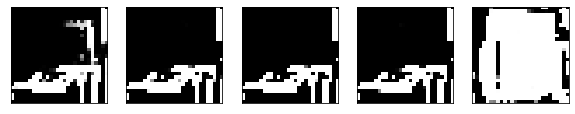

Época  47 Finalizada: Custo Discriminador 0.00340 - Custo Gerador 0.23525


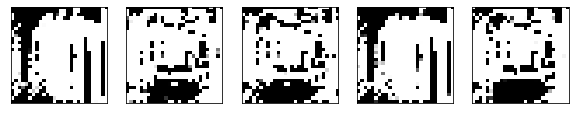

Época  48 Finalizada: Custo Discriminador 0.00340 - Custo Gerador 0.22265


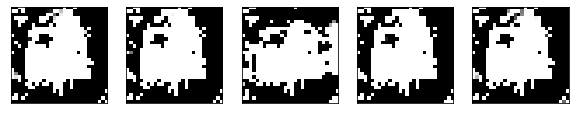

Época  49 Finalizada: Custo Discriminador 0.00339 - Custo Gerador 0.18847


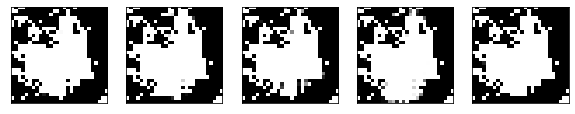

Época  50 Finalizada: Custo Discriminador 0.00339 - Custo Gerador 0.22741


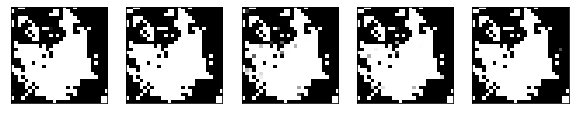

Época  51 Finalizada: Custo Discriminador 0.00339 - Custo Gerador 0.18588


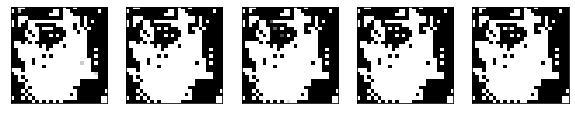

Época  52 Finalizada: Custo Discriminador 0.00339 - Custo Gerador 0.15654


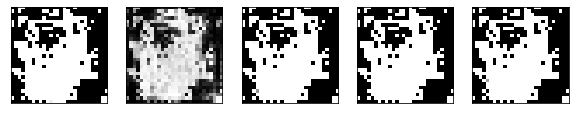

Época  53 Finalizada: Custo Discriminador 0.00339 - Custo Gerador 0.16222


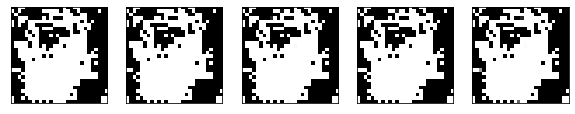

Época  54 Finalizada: Custo Discriminador 0.00347 - Custo Gerador 0.24551


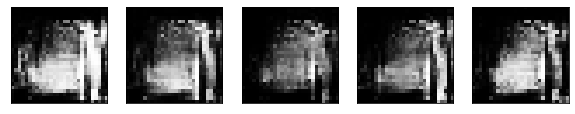

Época  55 Finalizada: Custo Discriminador 0.00362 - Custo Gerador 0.16272


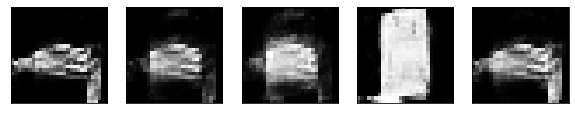

Época  56 Finalizada: Custo Discriminador 0.00373 - Custo Gerador 0.13608


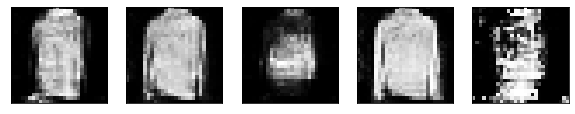

Época  57 Finalizada: Custo Discriminador 0.00368 - Custo Gerador 0.13950


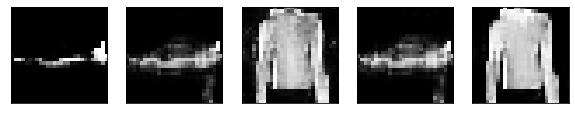

Época  58 Finalizada: Custo Discriminador 0.00372 - Custo Gerador 0.12586


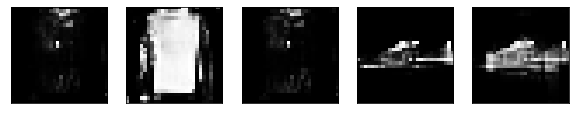

Época  59 Finalizada: Custo Discriminador 0.00368 - Custo Gerador 0.12524


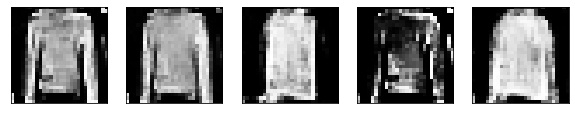

Época  60 Finalizada: Custo Discriminador 0.00364 - Custo Gerador 0.13511


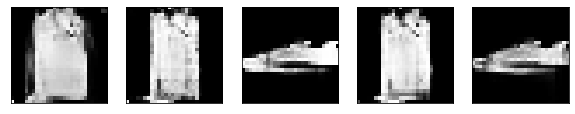

Época  61 Finalizada: Custo Discriminador 0.00379 - Custo Gerador 0.10594


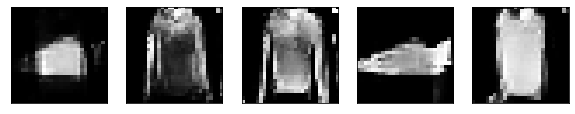

Época  62 Finalizada: Custo Discriminador 0.00383 - Custo Gerador 0.10549


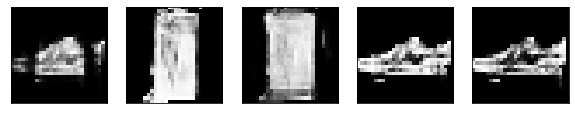

Época  63 Finalizada: Custo Discriminador 0.00374 - Custo Gerador 0.19581


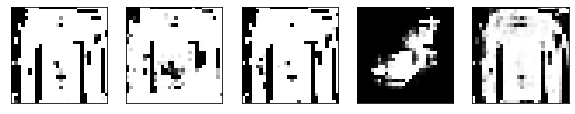

Época  64 Finalizada: Custo Discriminador 0.00348 - Custo Gerador 0.28838


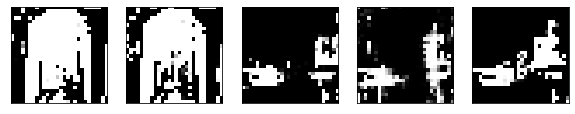

Época  65 Finalizada: Custo Discriminador 0.00343 - Custo Gerador 0.30371


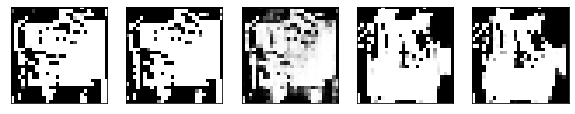

Época  66 Finalizada: Custo Discriminador 0.00343 - Custo Gerador 0.21334


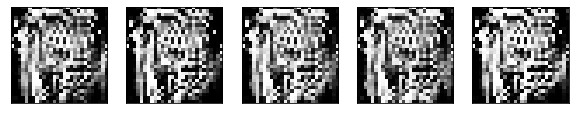

Época  67 Finalizada: Custo Discriminador 0.00343 - Custo Gerador 0.23152


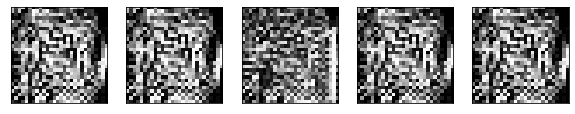

Época  68 Finalizada: Custo Discriminador 0.00342 - Custo Gerador 0.25048


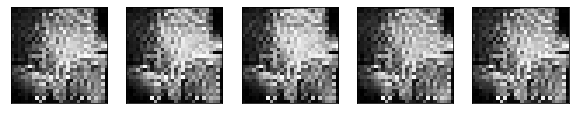

Época  69 Finalizada: Custo Discriminador 0.00356 - Custo Gerador 0.24028


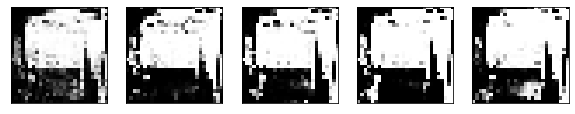

Época  70 Finalizada: Custo Discriminador 0.00346 - Custo Gerador 0.20431


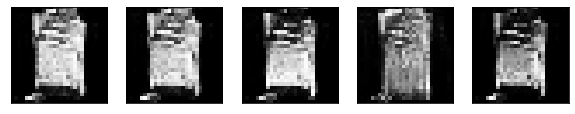

Época  71 Finalizada: Custo Discriminador 0.00350 - Custo Gerador 0.20042


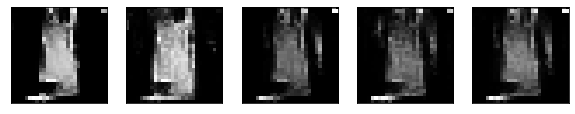

Época  72 Finalizada: Custo Discriminador 0.00347 - Custo Gerador 0.19380


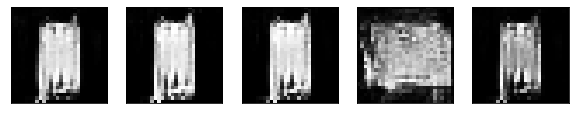

Época  73 Finalizada: Custo Discriminador 0.00351 - Custo Gerador 0.15596


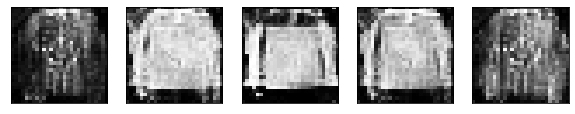

Época  74 Finalizada: Custo Discriminador 0.00354 - Custo Gerador 0.18831


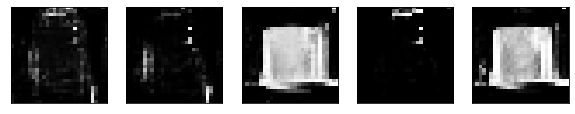

Época  75 Finalizada: Custo Discriminador 0.00350 - Custo Gerador 0.17601


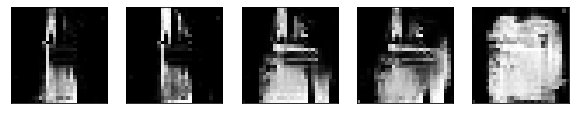

Época  76 Finalizada: Custo Discriminador 0.00350 - Custo Gerador 0.27680


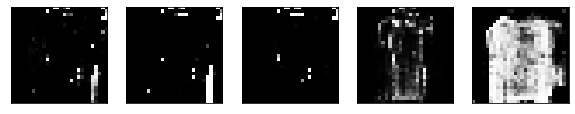

Época  77 Finalizada: Custo Discriminador 0.00340 - Custo Gerador 0.18105


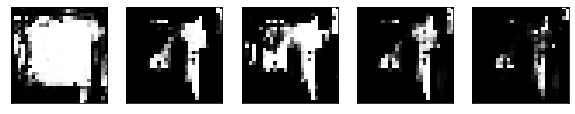

Época  78 Finalizada: Custo Discriminador 0.00344 - Custo Gerador 0.24142


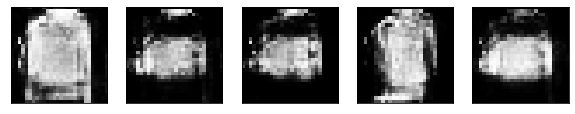

Época  79 Finalizada: Custo Discriminador 0.00380 - Custo Gerador 0.14812


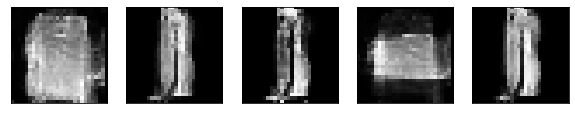

Época  80 Finalizada: Custo Discriminador 0.00377 - Custo Gerador 0.12689


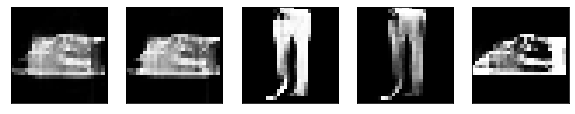

Época  81 Finalizada: Custo Discriminador 0.00381 - Custo Gerador 0.10667


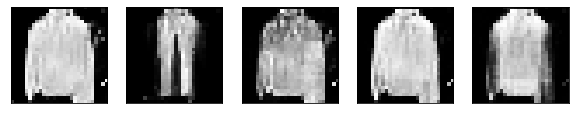

Época  82 Finalizada: Custo Discriminador 0.00381 - Custo Gerador 0.11482


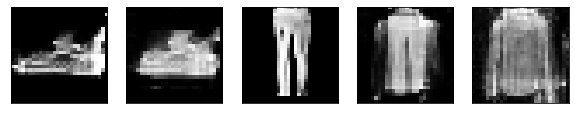

Época  83 Finalizada: Custo Discriminador 0.00405 - Custo Gerador 0.10363


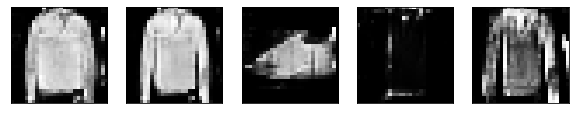

Época  84 Finalizada: Custo Discriminador 0.00379 - Custo Gerador 0.11529


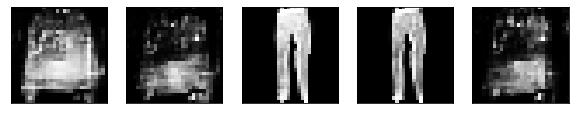

Época  85 Finalizada: Custo Discriminador 0.00371 - Custo Gerador 0.13555


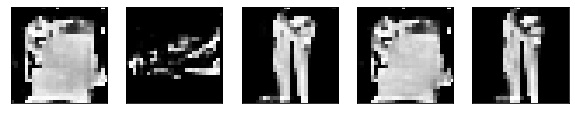

Época  86 Finalizada: Custo Discriminador 0.00362 - Custo Gerador 0.15460


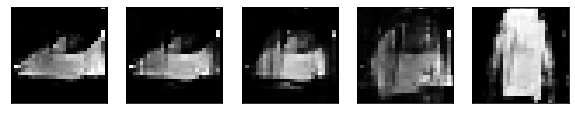

Época  87 Finalizada: Custo Discriminador 0.00378 - Custo Gerador 0.12729


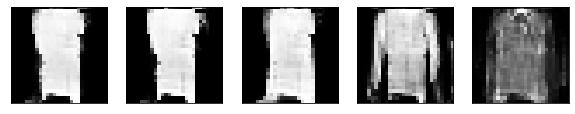

Época  88 Finalizada: Custo Discriminador 0.00365 - Custo Gerador 0.11972


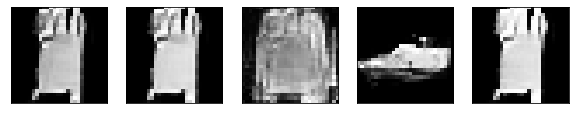

Época  89 Finalizada: Custo Discriminador 0.00369 - Custo Gerador 0.12848


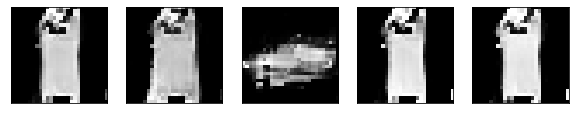

Época  90 Finalizada: Custo Discriminador 0.00370 - Custo Gerador 0.12856


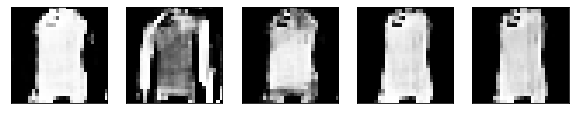

Época  91 Finalizada: Custo Discriminador 0.00371 - Custo Gerador 0.11677


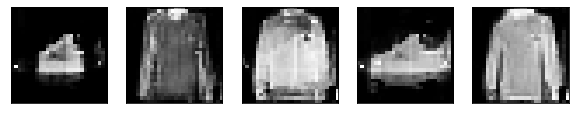

Época  92 Finalizada: Custo Discriminador 0.00378 - Custo Gerador 0.11888


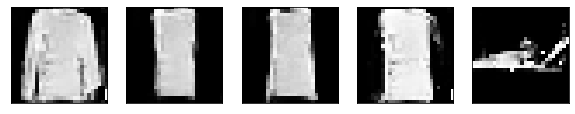

Época  93 Finalizada: Custo Discriminador 0.00375 - Custo Gerador 0.12717


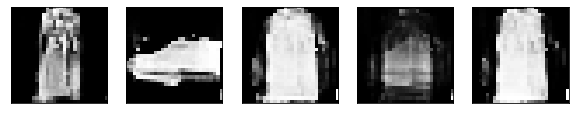

Época  94 Finalizada: Custo Discriminador 0.00370 - Custo Gerador 0.12208


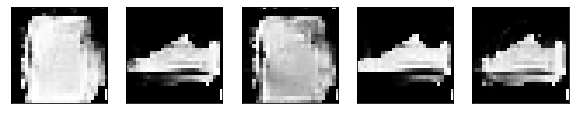

Época  95 Finalizada: Custo Discriminador 0.00368 - Custo Gerador 0.11280


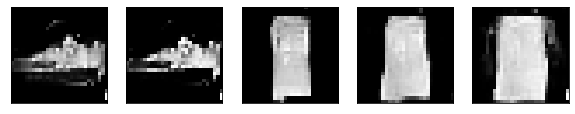

Época  96 Finalizada: Custo Discriminador 0.00366 - Custo Gerador 0.12560


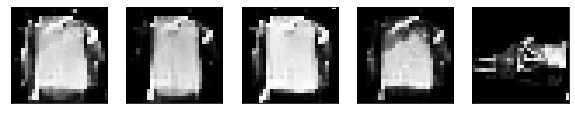

Época  97 Finalizada: Custo Discriminador 0.00366 - Custo Gerador 0.13324


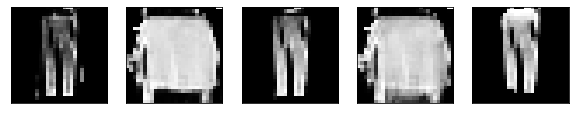

Época  98 Finalizada: Custo Discriminador 0.00384 - Custo Gerador 0.12191


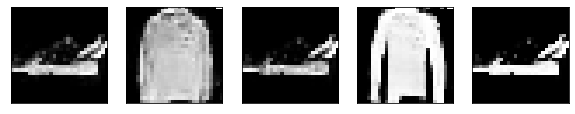

Época  99 Finalizada: Custo Discriminador 0.00369 - Custo Gerador 0.15150


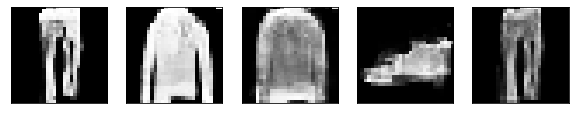

Época 100 Finalizada: Custo Discriminador 0.00376 - Custo Gerador 0.11711


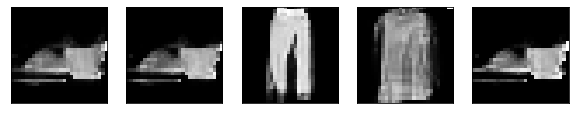

In [ ]:
for epoch in range(100):
  D_running_loss = 0.
  G_running_loss = 0.
  for i, (imagens_reais, _) in enumerate(train_loader): # Pega somente os inputs o _ ignora os labels
    batch_size = imagens_reais.size(0)
    
    # Ex pixel = 0 * 2 - 1 = -1 # Faz isso por causa da tanh retorna valor de -1 a 1 e o train_loader pelo formato torch deixa de 0 a 1 normalizado
    # Ex pixel = 1 * 2 - 1 = 1
    imagens_reais = imagens_reais * 2 - 1
    imagens_reais = imagens_reais.to(device)


    # Treinamento do Gerador
    G_optimizer.zero_grad() # Zerar o gradiente
    ruido = np.random.uniform(low=-1., high=1., size=(batch_size, 100)) # gera nosso ruido para rede
    ruido = torch.from_numpy(ruido).float().to(device)
    #print((ruido.shape))
    imagens_falsas = G.forward(ruido)


    outputs_falsas = D.forward(imagens_falsas)

    labels_falsas = torch.ones(batch_size).to(device) # Criando vetor de 256 posições
    #print(labels_falsas.shape)
    #print(len(labels_falsas))
    G_loss = criterion(outputs_falsas.view(*labels_falsas.shape), labels_falsas) # View em outputs falsas é para realizar a conversão dos outputs 
    G_loss.backward()
    G_optimizer.step()

    # Treinamento do Discriminador
    D_optimizer.zero_grad()
    
    outputs_reais =  D.forward(imagens_reais)
    
    labels_reais = (torch.ones(batch_size)*0.9).to(device) # Suavização das saidas
    D_loss_reais = criterion(outputs_reais.view(*labels_reais.shape), labels_reais)

    ruido = np.random.uniform(low=-1., high=1., size=(batch_size, 100)) # gera nosso ruido para rede 
    ruido = torch.from_numpy(ruido).float().to(device)
    
    imagens_falsas = G.forward(ruido)
    outputs_falsas =  D.forward(imagens_falsas)

    labels_falsas = torch.zeros(batch_size).to(device)

    D_loss_falsas = criterion(outputs_falsas.view(*labels_falsas.shape), labels_falsas)

    D_loss = D_loss_reais + D_loss_falsas
    D_loss.backward()
    D_optimizer.step()

    D_running_loss += D_loss.item()
    G_running_loss += G_loss.item()
  
  D_running_loss /= len(train_loader)
  G_running_loss /= len(train_loader)

  print('\rÉpoca {:3d} Finalizada: Custo Discriminador {:.5f} - Custo Gerador {:.5f}'.format(epoch+1, 
                                                            D_running_loss/(batch_size),
                                                            G_running_loss/(batch_size)))
  fig, ax = plt.subplots(1, 5, figsize=(10,5))
  for i in range(5):
    ax[i].imshow(imagens_falsas.cpu().detach().numpy()[i].reshape(28,28), cmap='gray')
    ax[i].yaxis.set_visible(False)
    ax[i].xaxis.set_visible(False)
  plt.show()

# Criação de Novas Imagens

In [ ]:
ruido = np.random.uniform(-1.,1.,(20,100))

In [ ]:
ruido = torch.from_numpy(ruido).float().to(device)

In [ ]:
G.eval()
previsao = G.forward(ruido)

In [ ]:
previsao = previsao.cpu().detach().numpy()

In [ ]:
previsao.shape[0]

20

In [ ]:
previsao.shape

(20, 1, 28, 28)

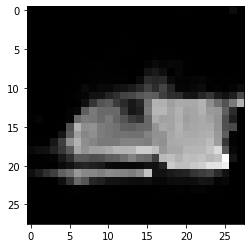

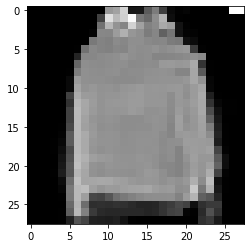

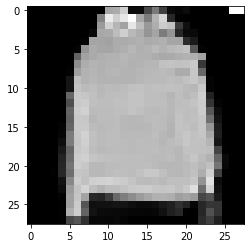

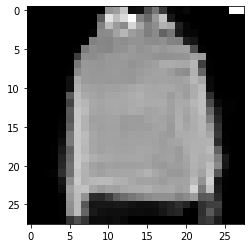

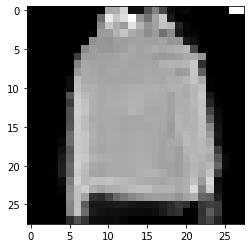

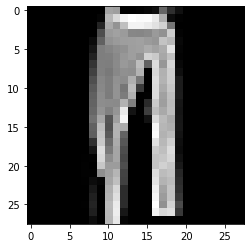

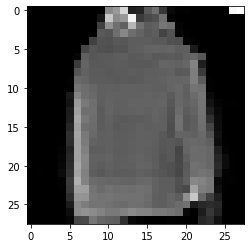

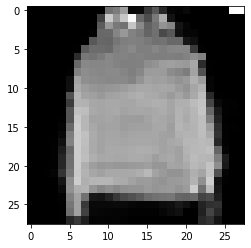

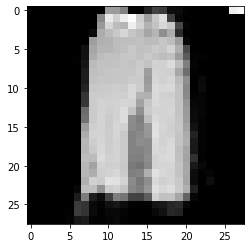

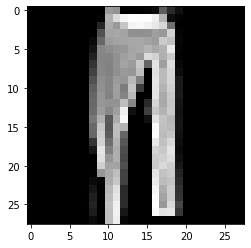

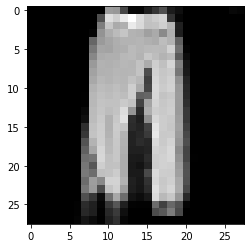

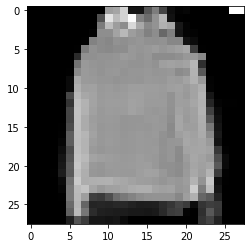

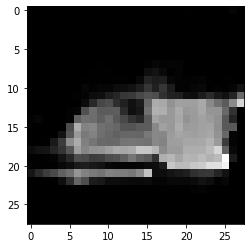

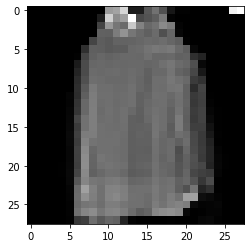

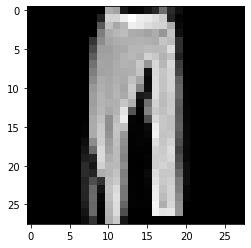

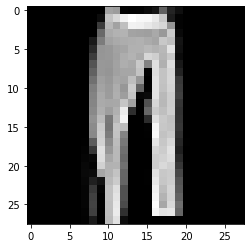

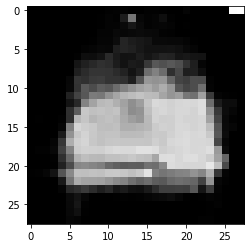

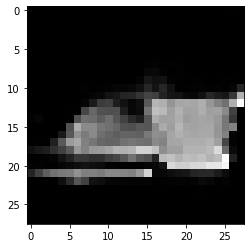

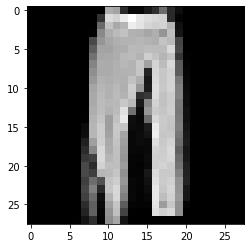

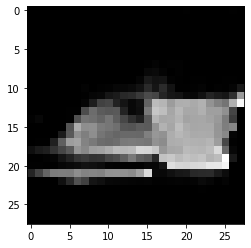

In [ ]:
for i in range(previsao.shape[0]):
    plt.imshow(previsao[i,:].squeeze(),cmap='gray')
    plt.show()